# Next Word Prediction

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
import datetime
import nltk
import string
import os
import re
from nltk.corpus import stopwords
from tensorflow.keras.models import load_model, save_model
from nltk.util import bigrams
from collections import Counter
from nltk.tokenize import word_tokenize
from keras.models import load_model
from sklearn.model_selection import train_test_split
import spacy
from openpyxl.workbook import Workbook
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
nlp = spacy.load("en_core_web_sm")

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#Libraries for visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
import csv

filtered_sentences = []

with open('PreprocssedData - Sheet1.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        filtered_sentences.append(row)

In [ ]:
len(filtered_sentences)

22666

In [ ]:
col_name = ["Sentences"]
df_filtered = pd.DataFrame(filtered_sentences,columns=col_name)

df_filtered = df_filtered.iloc[6000:]

# Drop the last 6,000 rows
df_filtered = df_filtered.iloc[:-6000]

# Calculate the number of middle rows to drop
middle_rows_to_drop = 2665

# Drop the middle rows
middle_start = (len(df_filtered) - middle_rows_to_drop) // 2
middle_end = middle_start + middle_rows_to_drop
df_filtered = pd.concat([df_filtered.iloc[:middle_start], df_filtered.iloc[middle_end:]])

# Reset index after dropping rows
df_filtered = df_filtered.reset_index(drop=True)

In [ ]:
df_filtered

,Sentences
0,he could never recollect whether he had been t...
1,at last he was conscious of his former fever a...
2,soon heavy leaden sleep came over him as it we...
3,he slept an extraordinarily long time and with...
4,nastasya coming into his room at ten o clock t...
...,...
7996,later he sold the mounting to gaston de nephew...
7997,for nearly a century the house of had prided i...
7998,although adverse circumstances had greatly red...
7999,more particularly the present count clung to i...


In [ ]:
sentences = df_filtered['Sentences'].tolist()
words = [word_tokenize(sentence) for sentence in sentences]
words_without_stopwords = []
stop_words = set(stopwords.words('english'))
for line in words:
  for word in line:
    if word not in stop_words:
      words_without_stopwords.append(word)

In [ ]:
words_freq = Counter(words_without_stopwords)

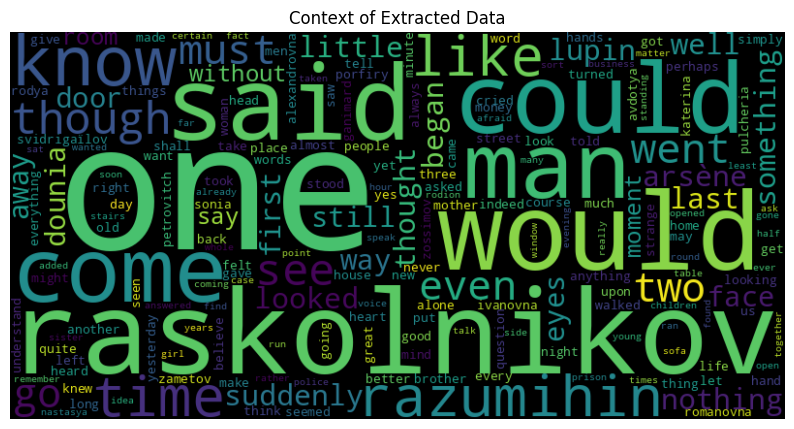

In [ ]:
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(words_freq)

plt.figure(figsize=(10, 8))
plt.title("Context of Extracted Data")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
word_lengths = df_filtered['Sentences'].apply(lambda x: len(x.split()))

fig = px.histogram(x=word_lengths, nbins=25, title='Distribution of Word Lengths in Filtered Sentences')
fig.update_layout(xaxis_title='Word Length', yaxis_title='Frequency')
fig.update_traces(marker=dict(line=dict(color='black', width=1)))
fig.show()

In [ ]:
sentences = df_filtered['Sentences'].tolist()
# Function to count stopwords and other words
def count_words(sentence):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(sentence)
    num_stopwords = len([word for word in words if word.lower() in stop_words])
    num_other_words = len(words) - num_stopwords
    return num_stopwords, num_other_words

# Count stopwords and other words for each sentence
total_stopwords, total_other_words = zip(*[count_words(sentence) for sentence in sentences])

# Create a grouped bar chart
fig = px.bar(x=['Stopwords', 'Other Words'], y=[sum(total_stopwords), sum(total_other_words)],
             title='Total Number of Stopwords and Other Words in All Sentences',
             labels={'value': 'Word Count', 'variable': 'Word Type'},
             color=['Stopwords', 'Other Words'])
fig.update_layout(barmode='group')

fig.show()

In [ ]:
sentences_tokenized = [word_tokenize(str(sentence).strip()) for sentence in df_filtered['Sentences']]
sentences_bigrams = [list(bigrams(tokens)) for tokens in sentences_tokenized]


structured_bigrams = []


for i, sentence_bigrams in enumerate(sentences_bigrams, start=1):
    for bigram in sentence_bigrams:
        structured_bigrams.append({
            'Sentence': f"Sentence {i}",
            'Bigram': ' '.join(bigram)
        })

df_bigrams = pd.DataFrame(structured_bigrams)

bigram_counts = df_bigrams['Bigram'].value_counts().reset_index()
bigram_counts.columns = ['Bigram', 'Frequency']


df_bigrams = df_bigrams.merge(bigram_counts, on='Bigram')

# Calculate bigram probabilities
df_bigrams['Probability'] = df_bigrams.groupby('Sentence')['Frequency'].transform(lambda x: x / x.sum())


In [ ]:
df_bigrams

,Sentence,Bigram,Frequency,Probability
0,Sentence 1,he could,108,0.156522
1,Sentence 2,he could,108,0.070913
2,Sentence 22,he could,108,0.076003
3,Sentence 31,he could,108,0.124567
4,Sentence 35,he could,108,0.187826
...,...,...,...,...
126732,Sentence 8001,had rented,1,0.001172
126733,Sentence 8001,rented a,1,0.001172
126734,Sentence 8001,box at,1,0.001172
126735,Sentence 8001,lyonnais in,1,0.001172


In [ ]:
vectorizer = TfidfVectorizer()
filtered_sentences_TFIDF = vectorizer.fit_transform(df_filtered['Sentences'].tolist())

In [ ]:
filtered_sentences_TFIDF

<8001x8439 sparse matrix of type '<class 'numpy.float64'>'
	with 114406 stored elements in Compressed Sparse Row format>

In [ ]:
# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(filtered_sentences_TFIDF.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df

,aback,abandon,abandoned,abandoning,abbey,aberration,abjure,able,abnormal,abnormality,...,zametov,zaraïsk,zarnitsyn,zeal,zest,zigzags,zossimov,æsthetically,æsthetics,êtes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split

# Bigram with LSTM

In [ ]:
bigrams = df_bigrams['Bigram'].tolist()

tokenizer_bigrams = Tokenizer()
tokenizer_bigrams.fit_on_texts(bigrams)

total_words_bigrams = len(tokenizer_bigrams.word_index) + 1

input_sequences_bigrams = []
for bigram in bigrams:
    tokenized_bigram = tokenizer_bigrams.texts_to_sequences([bigram])[0]
    for i in range(1, len(tokenized_bigram)):
        n_gram_sequence_bigrams = tokenized_bigram[:i+1]
        input_sequences_bigrams.append(n_gram_sequence_bigrams)

max_sequence_length_bigrams = max([len(x) for x in input_sequences_bigrams])
input_sequences_bigrams = pad_sequences(input_sequences_bigrams, maxlen=max_sequence_length_bigrams, padding='pre')

X_bigrams, y_bigrams = input_sequences_bigrams[:, :-1], input_sequences_bigrams[:, -1]

X_train, X_val, y_train, y_val = train_test_split(X_bigrams, y_bigrams, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.layers import Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model_bigrams = Sequential()
model_bigrams.add(Embedding(total_words_bigrams, 50, input_length=max_sequence_length_bigrams-1))
model_bigrams.add(LSTM(100))
model_bigrams.add(Dense(total_words_bigrams, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model_bigrams.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_bigrams.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
3169/3169 [==============================] - 35s 9ms/step - loss: 6.5228 - accuracy: 0.0628 - val_loss: 6.0714 - val_accuracy: 0.0798
Epoch 2/10
3169/3169 [==============================] - 24s 7ms/step - loss: 5.7839 - accuracy: 0.1048 - val_loss: 5.8042 - val_accuracy: 0.1179
Epoch 3/10
3169/3169 [==============================] - 24s 8ms/step - loss: 5.4936 - accuracy: 0.1301 - val_loss: 5.7251 - val_accuracy: 0.1297
Epoch 4/10
3169/3169 [==============================] - 26s 8ms/step - loss: 5.3110 - accuracy: 0.1449 - val_loss: 5.7051 - val_accuracy: 0.1333
Epoch 5/10
3169/3169 [==============================] - 24s 8ms/step - loss: 5.1719 - accuracy: 0.1535 - val_loss: 5.7039 - val_accuracy: 0.1368
Epoch 6/10
3169/3169 [==============================] - 23s 7ms/step - loss: 5.0519 - accuracy: 0.1616 - val_loss: 5.7183 - val_accuracy: 0.1388
Epoch 7/10
3169/3169 [==============================] - 26s 8ms/step - loss: 4.9473 - accuracy: 0.1675 - val_loss: 5.7265 - val_ac

In [ ]:
model_bigrams.save('bigram_DL_model.keras')

In [ ]:
loaded_bigram_model = load_model('bigram_DL_model.keras')
bigrams = df_bigrams['Bigram'].tolist()
tokenizer_bigrams = Tokenizer()
tokenizer_bigrams.fit_on_texts(bigrams)
input_sequences_bigrams = []
for bigram in bigrams:
    tokenized_bigram = tokenizer_bigrams.texts_to_sequences([bigram])[0]
    for i in range(1, len(tokenized_bigram)):
        n_gram_sequence_bigrams = tokenized_bigram[:i+1]
        input_sequences_bigrams.append(n_gram_sequence_bigrams)

def visualize_next_word_bigrams(input_words):
    max_sequence_length_bigrams = max([len(x) for x in input_sequences_bigrams])
    input_sequence_bigrams = tokenizer_bigrams.texts_to_sequences([input_words])[0]
    input_sequence_bigrams = pad_sequences([input_sequence_bigrams], maxlen=max_sequence_length_bigrams - 1, padding='pre')
    predicted_probabilities_bigrams = loaded_bigram_model.predict(input_sequence_bigrams, verbose=0).flatten()

    # Get the top 5 predicted words and their probabilities
    top_n_bigrams = 5
    top_indices_bigrams = predicted_probabilities_bigrams.argsort()[-top_n_bigrams:][::-1]
    top_words_bigrams = [tokenizer_bigrams.index_word.get(idx, "<Unknown>") for idx in top_indices_bigrams]
    top_probabilities_bigrams = predicted_probabilities_bigrams[top_indices_bigrams]

    # Create a bar chart
    fig = go.Figure(data=[go.Bar(x=top_words_bigrams, y=top_probabilities_bigrams)])
    fig.update_layout(title=f'Next Word Prediction for "{input_words}" (Bigrams)',
                      xaxis_title='Next Word',
                      yaxis_title='Probability',
                      hovermode='x',
                      hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial"))

    fig.show()

In [ ]:
# Interactive next word prediction with visualization for Bigrams
while True:
    input_words_bigrams = input("Enter words for bigrams (or press Enter to stop): ").lower()
    if not input_words_bigrams:
        break
    visualize_next_word_bigrams(input_words_bigrams)

Enter words for bigrams (or press Enter to stop): he was


Enter words for bigrams (or press Enter to stop): he was a


Enter words for bigrams (or press Enter to stop): hi


Enter words for bigrams (or press Enter to stop): 


In [ ]:
loss_bigram_lstm, accuracy_bigram_lstm = loaded_bigram_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {accuracy_bigram_lstm * 100:.2f}%")
print(f"Validation Loss: {loss_bigram_lstm}")

Validation Accuracy: 14.21%
Validation Loss: 5.784286022186279


In [ ]:

predicted_indices = np.argmax(loaded_bigram_model.predict(X_val), axis=1)


predicted_words = tokenizer_bigrams.sequences_to_texts([predicted_indices])[0]
actual_words = tokenizer_bigrams.sequences_to_texts([y_val])[0]

confusion_mat = confusion_matrix(actual_words.split(), predicted_words.split())
print("Confusion Matrix of Bigram LSTM:")
print(confusion_mat)

793/793 [==============================] - 3s 4ms/step
Confusion Matrix of Bigram LSTM:
[[183   0   1 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  3   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


# TFIDF with LSTM

In [ ]:
# Use TfidfVectorizer to create a TFIDF matrix
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_filtered['Sentences'])

# Extract feature names from the TFIDF dataset
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_names = feature_names.tolist()
# Convert TFIDF matrix to input sequences
input_sequences_tfidf = []
for i in range(tfidf_matrix.shape[0]):
    non_zero_indices = np.where(tfidf_matrix[i].toarray() > 0)[1]
    input_sequences_tfidf.extend([non_zero_indices[:j+1].tolist() for j in range(len(non_zero_indices))])

max_sequence_length_tfidf = max([len(x) for x in input_sequences_tfidf])
input_sequences_tfidf = pad_sequences(input_sequences_tfidf, maxlen=max_sequence_length_tfidf, padding='pre')

X_tfidf, y_tfidf = input_sequences_tfidf[:, :-1], input_sequences_tfidf[:, -1]

# Split the data into training and testing sets
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=42)

total_words_tfidf = len(feature_names) + 1

In [ ]:
# Define LSTM model
model_tfidf_lstm = Sequential()
model_tfidf_lstm.add(Embedding(total_words_tfidf, 50, input_length=max_sequence_length_tfidf-1))
model_tfidf_lstm.add(LSTM(100))
model_tfidf_lstm.add(Dense(total_words_tfidf, activation='softmax'))

model_tfidf_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the LSTM model
model_tfidf_lstm.fit(X_train_tfidf, y_train_tfidf, epochs=10, verbose=1)

Epoch 1/10
2861/2861 [==============================] - 43s 14ms/step - loss: 6.2984 - accuracy: 0.0933
Epoch 2/10
2861/2861 [==============================] - 24s 8ms/step - loss: 5.3530 - accuracy: 0.1551
Epoch 3/10
2861/2861 [==============================] - 23s 8ms/step - loss: 5.0821 - accuracy: 0.1690
Epoch 4/10
2861/2861 [==============================] - 22s 8ms/step - loss: 4.8868 - accuracy: 0.1765
Epoch 5/10
2861/2861 [==============================] - 22s 8ms/step - loss: 4.7138 - accuracy: 0.1848
Epoch 6/10
2861/2861 [==============================] - 21s 7ms/step - loss: 4.5510 - accuracy: 0.1913
Epoch 7/10
2861/2861 [==============================] - 23s 8ms/step - loss: 4.3951 - accuracy: 0.1982
Epoch 8/10
2861/2861 [==============================] - 22s 8ms/step - loss: 4.2465 - accuracy: 0.2077
Epoch 9/10
2861/2861 [==============================] - 21s 7ms/step - loss: 4.1025 - accuracy: 0.2169
Epoch 10/10
2861/2861 [==============================] - 22s 8ms/step - 

In [ ]:
model_tfidf_lstm.save('tfidf_DL_model.keras')

In [ ]:
loaded_tfidf_model = load_model('tfidf_DL_model.keras')

In [ ]:
def visualize_next_word_tfidf(input_words):
    input_sequence_tfidf = [feature_names.index(word) + 1 for word in input_words.split() if word in feature_names]
    input_sequence_tfidf = pad_sequences([input_sequence_tfidf], maxlen=max_sequence_length_tfidf-1, padding='pre')
    predicted_probabilities_tfidf = loaded_tfidf_model.predict(input_sequence_tfidf, verbose=0).flatten()

    # Get the top N predicted words and their probabilities
    top_n_tfidf = 5
    top_indices_tfidf = predicted_probabilities_tfidf.argsort()[-top_n_tfidf:][::-1]
    top_words_tfidf = [feature_names[idx - 1] for idx in top_indices_tfidf]
    top_probabilities_tfidf = predicted_probabilities_tfidf[top_indices_tfidf]

    # Create a bar chart
    fig = go.Figure(data=[go.Bar(x=top_words_tfidf, y=top_probabilities_tfidf)])
    fig.update_layout(title=f'Next Word Prediction for "{input_words}" (TFIDF)',
                      xaxis_title='Next Word',
                      yaxis_title='Probability',
                      hovermode='x',
                      hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial"))

    fig.show()

In [ ]:
while True:
    input_words_tfidf = input("Enter words for TFIDF (or press Enter to stop): ").lower()
    if not input_words_tfidf:
        break
    visualize_next_word_tfidf(input_words_tfidf)

Enter words for TFIDF (or press Enter to stop): he was


Enter words for TFIDF (or press Enter to stop): today


Enter words for TFIDF (or press Enter to stop): alive


Enter words for TFIDF (or press Enter to stop): 


In [ ]:
# Evaluate the model on validation data
loss_tfidf_lstm, accuracy_tfidf_lstm = loaded_tfidf_model.evaluate(X_test_tfidf, y_test_tfidf, verbose=0)
print(f"Validation Accuracy: {accuracy_tfidf_lstm * 100:.2f}%")
print(f"Validation Loss: {loss_tfidf_lstm}")

Validation Accuracy: 16.18%
Validation Loss: 5.810515403747559


In [ ]:
predicted_indices = np.argmax(loaded_tfidf_model.predict(X_test_tfidf), axis=1)


confusion_mat = confusion_matrix(y_test_tfidf, predicted_indices)

print("Confusion Matrix of TFIDF LSTM:")
print(confusion_mat)

716/716 [==============================] - 3s 4ms/step
Confusion Matrix of TFIDF LSTM:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Filtered sentences with LSTM

In [ ]:

sentences = df_filtered['Sentences'].tolist()
print("No. of sentences:",len(sentences))
# Tokenize the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

total_words = len(tokenizer.word_index) + 1

# Create input sequences and labels
input_sequences = []
for sentence in sentences:
    tokenized_sentence = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(tokenized_sentence)):
        n_gram_sequence = tokenized_sentence[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_length = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')

X, y = input_sequences[:, :-1], input_sequences[:, -1]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


No. of sentences: 8001


In [ ]:
# Build the RNN model
model_filtered = Sequential()
model_filtered.add(Embedding(total_words, 50, input_length=max_sequence_length-1))
model_filtered.add(LSTM(100))
model_filtered.add(Dense(total_words, activation='softmax'))

model_filtered.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_filtered.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
3169/3169 [==============================] - 52s 16ms/step - loss: 6.4571 - accuracy: 0.0620
Epoch 2/10
3169/3169 [==============================] - 31s 10ms/step - loss: 5.6754 - accuracy: 0.1151
Epoch 3/10
3169/3169 [==============================] - 31s 10ms/step - loss: 5.2860 - accuracy: 0.1411
Epoch 4/10
3169/3169 [==============================] - 30s 9ms/step - loss: 5.0132 - accuracy: 0.1584
Epoch 5/10
3169/3169 [==============================] - 31s 10ms/step - loss: 4.7798 - accuracy: 0.1716
Epoch 6/10
3169/3169 [==============================] - 30s 9ms/step - loss: 4.5669 - accuracy: 0.1838
Epoch 7/10
3169/3169 [==============================] - 30s 9ms/step - loss: 4.3715 - accuracy: 0.1963
Epoch 8/10
3169/3169 [==============================] - 30s 9ms/step - loss: 4.1869 - accuracy: 0.2099
Epoch 9/10
3169/3169 [==============================] - 29s 9ms/step - loss: 4.0137 - accuracy: 0.2263
Epoch 10/10
3169/3169 [==============================] - 30s 9ms/step

In [ ]:
model_filtered.save('filtered_DL_model.keras')

In [ ]:
loaded_filtered_model = load_model('filtered_DL_model.keras')

In [ ]:
def visualize_next_word(input_words):
    input_sequence = tokenizer.texts_to_sequences([input_words])[0]
    input_sequence = pad_sequences([input_sequence], maxlen=max_sequence_length-1, padding='pre')
    predicted_probabilities = loaded_filtered_model.predict(input_sequence, verbose=0).flatten()


    top_n = 5
    top_indices = predicted_probabilities.argsort()[-top_n:][::-1]
    top_words = [tokenizer.index_word.get(idx, "<Unknown>") for idx in top_indices]
    top_probabilities = predicted_probabilities[top_indices]

    fig = go.Figure(data=[go.Bar(x=top_words, y=top_probabilities)])
    fig.update_layout(title=f'Next Word Prediction for "{input_words}"',
                      xaxis_title='Next Word',
                      yaxis_title='Probability',
                      hovermode='x',
                      hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial"))

    fig.show()

In [ ]:
while True:
    input_words = input("Enter words (or press Enter to stop): ").lower()
    if not input_words:
        break
    visualize_next_word(input_words)

Enter words (or press Enter to stop): what is


Enter words (or press Enter to stop): he was a


Enter words (or press Enter to stop): he was a great man


Enter words (or press Enter to stop): he was a great man who


Enter words (or press Enter to stop): 


In [ ]:
# Evaluate the model on the test set
loss_filtered_lstm, accuracy_filtered_lstm = loaded_filtered_model.evaluate(X_test, y_test, verbose=0)

print(f'Model Accuracy on Test Set: {accuracy_filtered_lstm * 100:.2f}%')
print(f'Model Loss on Test Set: {loss_filtered_lstm}')

Model Accuracy on Test Set: 20.83%
Model Loss on Test Set: 6.031557083129883


In [ ]:
predicted_indices = np.argmax(loaded_filtered_model.predict(X_test), axis=1)


confusion_mat = confusion_matrix(y_test, predicted_indices)

print("Confusion Matrix of filtered LSTM:")
print(confusion_mat)

793/793 [==============================] - 5s 5ms/step
Confusion Matrix of filtered LSTM:
[[572  50  30 ...   0   0   0]
 [ 29 368  80 ...   0   0   0]
 [ 30  97 318 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]]


In [ ]:
deep_learning_models_accuracies = {
    'Bigram LSTM': accuracy_bigram_lstm,
    'Tfidf LSTM': accuracy_tfidf_lstm,
    'Filtered Sentences': accuracy_filtered_lstm
}


df_accuracies = pd.DataFrame(deep_learning_models_accuracies.items(), columns=['Model', 'Accuracy'])


DL_comparison_bar = px.bar(df_accuracies, x='Model', y='Accuracy', title='Comparison of Deep Learning Models',color='Model')
DL_comparison_bar.show()

In [ ]:
deep_learning_models_loss = {
    'Bigram LSTM': loss_bigram_lstm,
    'Tfidf LSTM': loss_tfidf_lstm,
    'Filtered Sentences': loss_filtered_lstm
}


df_accuracies = pd.DataFrame(deep_learning_models_accuracies.items(), columns=['Model', 'Loss'])


DL_comparison_bar = px.bar(df_accuracies, x='Model', y='Loss', title='Comparison of Deep Learning Models',color='Model')
DL_comparison_bar.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Bigram with SVM

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import csr_matrix
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

df_bigrams['ProbabilityClass'] = pd.cut(df_bigrams['Probability'], bins=bins, labels=labels, include_lowest=True)

X = df_bigrams[['Bigram']]
y = df_bigrams['ProbabilityClass']

vectorizer = DictVectorizer(sparse=True)
X_vectorized = vectorizer.fit_transform(X.to_dict(orient='records'))

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

In [ ]:
svm_bigram = SVC(kernel='linear')
svm_bigram.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
import pickle

In [ ]:
filename = 'bigram_svm.sav'
pickle.dump(svm_bigram, open(filename, 'wb'))
filename = 'bigram_svm_vectorizer.sav'
pickle.dump(vectorizer, open(filename, 'wb'))

In [ ]:
filename = 'bigram_svm.sav'
loaded_model_bigram_svm = pickle.load(open(filename, 'rb'))
filename = 'bigram_svm_vectorizer.sav'
loaded_vectorizer_bigram_svm = pickle.load(open(filename, 'rb'))


def predict_next_word_svm_bigram(input_sentence, max_length=15):
    words = input_sentence.lower().split()
    input_length = len(words)

    if input_length < 1:
        return "Input should contain at least one word."

    predicted_word = ''

    for _ in range(max_length - input_length):
        input_bigram = ' '.join(words[-2:]) if len(words) >= 2 else words[-1]

        input_data = {'Bigram': input_bigram}
        input_vectorized = loaded_vectorizer_bigram_svm.transform([input_data])
        predicted_class = loaded_model_bigram_svm.predict(input_vectorized)

        possible_words = df_bigrams[df_bigrams['ProbabilityClass'] == predicted_class[0]]['Bigram']
        filtered_words = possible_words[possible_words.str.startswith(input_bigram)]

        if len(filtered_words) > 0:
            predicted_word = filtered_words.sample().values[0].split()[1]
            return predicted_word

        if predicted_word.endswith('.'):
            break

    return "No valid prediction"


In [ ]:
while True:
    input_words_bigrams = input("Enter words for bigrams (or press Enter to stop): ").lower()
    if not input_words_bigrams:
        break

    predicted_next_word = predict_next_word_svm_bigram(input_words_bigrams)
    print("Predicted next word for bigrams:", predicted_next_word)

Enter words for bigrams (or press Enter to stop): hey
Predicted next word for bigrams: my
Enter words for bigrams (or press Enter to stop): hey my
Predicted next word for bigrams: my
Enter words for bigrams (or press Enter to stop): hey my father
Predicted next word for bigrams: father
Enter words for bigrams (or press Enter to stop): what are you
Predicted next word for bigrams: young
Enter words for bigrams (or press Enter to stop): where is your
Predicted next word for bigrams: your
Enter words for bigrams (or press Enter to stop): 


In [ ]:
y_pred = loaded_model_bigram_svm.predict(X_test)
accuracy_bigram_svm = accuracy_score(y_test, y_pred)

print(f"Accuracy on the test set: {accuracy_bigram_svm*100:.2f}%")

Accuracy on the test set: 91.24%


In [ ]:
precision_b_svm, recall_b_svm, f1_score_b_svm, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')


bigram_svm_df = pd.DataFrame({
    'Metric': ['Accuracy','Precision', 'Recall', 'F1-Score'],
    'Score': [accuracy_bigram_svm,precision_b_svm, recall_b_svm, f1_score_b_svm]
})

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



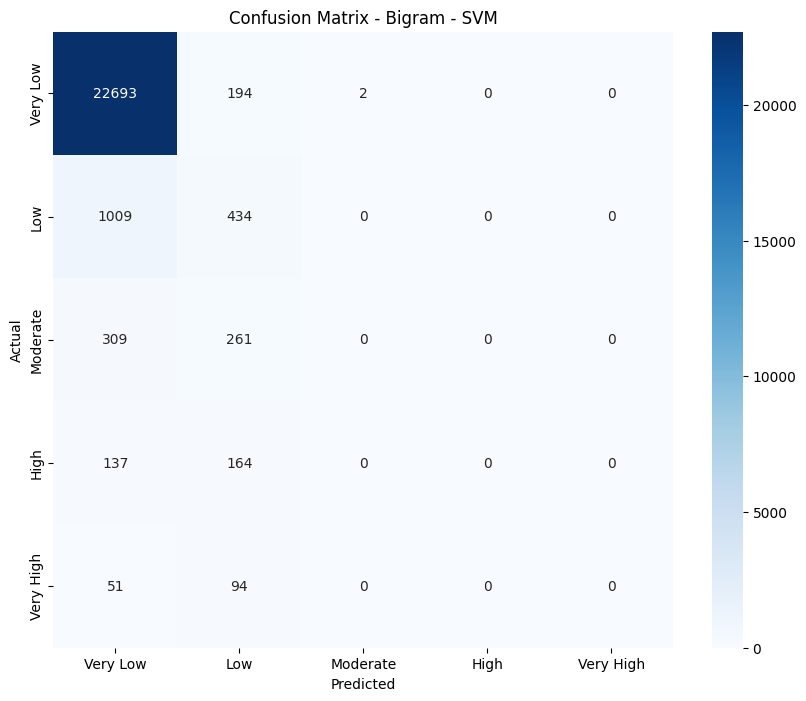

In [ ]:
predicted_labels = loaded_model_bigram_svm.predict(X_test)


confusion_mat = confusion_matrix(y_test, predicted_labels, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Bigram - SVM')
plt.show()

# TFIDF with SVM

In [ ]:
vectorizer = TfidfVectorizer()
filtered_sentences_TFIDF = vectorizer.fit_transform(df_filtered['Sentences'].tolist())
y = [word for sentence in sentences_tokenized for word in sentence][1:]
y = y[:filtered_sentences_TFIDF.shape[0]]
X_train, X_test, y_train, y_test = train_test_split(filtered_sentences_TFIDF, y, test_size=0.2, random_state=42)

In [ ]:
# Train an SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
filename = 'tfidf_svm.sav'
pickle.dump(svm_model, open(filename, 'wb'))
filename = 'tfidf_Vector_svm.sav'
pickle.dump(vectorizer, open(filename, 'wb'))

In [ ]:

filename = 'tfidf_svm.sav'
loaded_model_tfidf_svm = pickle.load(open(filename, 'rb'))
filename = 'tfidf_Vector_svm.sav'
loaded_vector_tfidf_svm = pickle.load(open(filename, 'rb'))

def predict_next_word_svm(input_bigram):
    input_bigram_tfidf = loaded_vector_tfidf_svm.transform([input_bigram])
    predicted_word = loaded_model_tfidf_svm.predict(input_bigram_tfidf)
    return predicted_word[0]

In [ ]:
while True:
    input_bigram = input("Enter words for bigram TF-IDF (or press Enter to stop): ").lower()
    if not input_bigram:
        break

    predicted_next_word = predict_next_word_svm(input_bigram)
    print("Predicted next word using SVM and TF-IDF:", predicted_next_word)

Enter words for bigram TF-IDF (or press Enter to stop): hi
Predicted next word using SVM and TF-IDF: the
Enter words for bigram TF-IDF (or press Enter to stop): what are
Predicted next word using SVM and TF-IDF: the
Enter words for bigram TF-IDF (or press Enter to stop): you
Predicted next word using SVM and TF-IDF: to
Enter words for bigram TF-IDF (or press Enter to stop): you to
Predicted next word using SVM and TF-IDF: to
Enter words for bigram TF-IDF (or press Enter to stop): you to bye
Predicted next word using SVM and TF-IDF: to
Enter words for bigram TF-IDF (or press Enter to stop): 


In [ ]:
y_pred = loaded_model_tfidf_svm.predict(X_test)
accuracy_tfidf_svm = accuracy_score(y_test, y_pred)

print(f"Accuracy on the test set: {accuracy_tfidf_svm*100:.2f}%")

precision_f_svm, recall_f_svm, f1_score_f_svm, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')


tfidf_svm_df = pd.DataFrame({
    'Metric': ['Accuracy','Precision', 'Recall', 'F1-Score'],
    'Score': [accuracy_tfidf_svm,precision_f_svm, recall_f_svm, f1_score_f_svm]
})

Accuracy on the test set: 6.81%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
predicted_labels = loaded_model_tfidf_svm.predict(X_test)

unique_labels = np.unique(y_test)
confusion_mat = confusion_matrix(y_test, predicted_labels, labels=unique_labels)
print("Confusion Matrix - TFIDF - SVM")
print(confusion_mat)

Confusion Matrix - TFIDF - SVM
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Filtered sentences with SVM

In [ ]:

X_train, X_test = train_test_split(df_filtered['Sentences'], test_size=0.2, random_state=42)


y_train = []
for sentence in X_train:
    words = sentence.split()
    if len(words) > 1:
        y_train.append(words[1])
    else:
        y_train.append('')

y_test = []
for sentence in X_test:
    words = sentence.split()
    if len(words) > 1:
        y_test.append(words[1])
    else:
        y_test.append('')

bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [ ]:
# Train an SVM model
svm_model_filtered = SVC(kernel='linear')
svm_model_filtered.fit(X_train_bow, y_train)

SVC(kernel='linear')

In [ ]:
filename = 'filtered_svm.sav'
pickle.dump(svm_model_filtered, open(filename, 'wb'))
filename = 'filtered_BOW_svm.sav'
pickle.dump(bow_vectorizer, open(filename, 'wb'))

In [ ]:
filename = 'filtered_svm.sav'
loaded_filtered_svm = pickle.load(open(filename, 'rb'))
filename = 'filtered_BOW_svm.sav'
loaded_filtered_BOW_svm = pickle.load(open(filename, 'rb'))

In [ ]:
def predict_next_word(sentence, model, vectorizer):

    sentence_bow = vectorizer.transform([sentence])


    predicted_word = model.predict(sentence_bow)
    return predicted_word[0] if predicted_word else None

In [ ]:
while True:
   sentence = input("Enter words for filtered svm (or press Enter to stop): ").lower()
   if not sentence:
      break

   predicted_next_word = predict_next_word(sentence,loaded_filtered_svm,loaded_filtered_BOW_svm)
   print("Predicted next word using SVM and Filtered Words(BoW):", predicted_next_word)

Enter words for filtered svm (or press Enter to stop): rolling up in the
Predicted next word using SVM and Filtered Words(BoW): the
Enter words for filtered svm (or press Enter to stop): bye
Predicted next word using SVM and Filtered Words(BoW): i
Enter words for filtered svm (or press Enter to stop): 


In [ ]:
X_test_bow = loaded_filtered_BOW_svm.transform(X_test)


y_pred = loaded_filtered_svm.predict(X_test_bow)

accuracy_filtered_svm = accuracy_score(y_test, y_pred)

precision_filtered_svm, recall_filtered_svm, f1_score_filtered_svm, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')


filtered_svm_df = pd.DataFrame({
    'Metric': ['Accuracy','Precision', 'Recall', 'F1-Score'],
    'Score': [accuracy_filtered_svm ,precision_filtered_svm, recall_filtered_svm, f1_score_filtered_svm]
})


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [ ]:
predicted_labels = loaded_filtered_svm.predict(X_test_bow)

unique_labels = np.unique(y_test)
confusion_mat = confusion_matrix(y_test, predicted_labels, labels=unique_labels)
print("Confusion Matrix - Filtered - SVM")
print(confusion_mat)

Confusion Matrix - Filtered - SVM
[[ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 13  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  1  0  1]]


# Comparison

In [ ]:
filtered_svm_df['Model'] = 'Filtered SVM'
tfidf_svm_df['Model'] = 'TF-IDF SVM'
bigram_svm_df['Model'] = 'Bigram SVM'


combined_df = pd.concat([filtered_svm_df, tfidf_svm_df, bigram_svm_df])

fig = px.bar(combined_df, x='Metric', y='Score', color='Model',
             title='Comparison of SVM Models Metrics',
             labels={'Score': 'Score Value'})
fig.show()

In [ ]:
svm_models_accuracies = {
    'Filtered SVM': accuracy_filtered_svm,
    'TF-IDF SVM': accuracy_tfidf_svm,
    'Bigram SVM': accuracy_bigram_svm
}

dl_df = pd.DataFrame(list(deep_learning_models_accuracies.items()), columns=['Model', 'Accuracy'])
svm_df = pd.DataFrame(list(svm_models_accuracies.items()), columns=['Model', 'Accuracy'])

dl_df['Type'] = 'Deep Learning'
svm_df['Type'] = 'SVM'


combined_accuracies = pd.concat([dl_df, svm_df])


fig = px.bar(combined_accuracies, x='Model', y='Accuracy', color='Type',
             title='Comparison of Model Accuracies',
             labels={'Accuracy': 'Accuracy Value'})
fig.show()

## **Final Verdict**
LSTM models, despite lower accuracy, exhibit more reliable word prediction in
real-world scenarios compared to SVMs. Further enhancements could focus on refining LSTM models to improve both
accuracy metrics and real-world predictive capabilities.